# Generalized and Spatial Forces

Just tinkering. Posture an arm, simulate a load, compute generalized forces, then recompute load.

In [1]:
import os

import numpy as np
from PIL import Image

In [2]:
from pydrake.common import FindResourceOrThrow
from pydrake.geometry.render import (
    ClippingRange,
    DepthRange,
    DepthRenderCamera,
    RenderCameraCore,
    RenderLabel,
    MakeRenderEngineVtk,
    RenderEngineVtkParams,
)
from pydrake.math import RigidTransform, RollPitchYaw
from pydrake.multibody.math import SpatialForce
from pydrake.multibody.parsing import Parser, GetScopedFrameName
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.multibody.tree import FrameIndex, JacobianWrtVariable
from pydrake.systems.framework import DiagramBuilder
from pydrake.systems.sensors import CameraInfo, RgbdSensor

In [3]:
np.set_printoptions(formatter={"float_kind": lambda x: f"{x:,.4f}"})

In [4]:
def xyz_rpy_deg(xyz, rpy_deg):
    """Shorthand for defining a pose."""
    rpy_deg = np.asarray(rpy_deg)
    return RigidTransform(RollPitchYaw(rpy_deg * np.pi / 180), xyz)

## Create a plant / diagram with a single IIWA.

In [5]:
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.0)

parser = Parser(plant)
iiwa_file = FindResourceOrThrow(
   "drake/manipulation/models/iiwa_description/sdf/"
   "iiwa14_no_collision.sdf")

iiwa = parser.AddModelFromFile(iiwa_file, model_name="iiwa")
plant.WeldFrames(
    frame_on_parent_P=plant.world_frame(),
    frame_on_child_C=plant.GetFrameByName("iiwa_link_0", iiwa),
    X_PC=xyz_rpy_deg([0, 0, 0], [0, 0, 0]),
)

renderer_name = "renderer"
scene_graph.AddRenderer(
    renderer_name, MakeRenderEngineVtk(RenderEngineVtkParams())
)

# N.B. These properties are chosen arbitrarily.
intrinsics = CameraInfo(width=640, height=480, fov_y=np.pi/4)
depth_camera = DepthRenderCamera(
    RenderCameraCore(
        renderer_name,
        intrinsics,
        ClippingRange(0.01, 10.0),
        RigidTransform(),
    ),
    DepthRange(0.01, 10.0),
)
world_id = plant.GetBodyFrameIdOrThrow(plant.world_body().index())
X_WB = xyz_rpy_deg([2, 0, 0.5], [-90, 0, 90])
sensor = RgbdSensor(
    world_id, X_PB=X_WB,
    depth_camera=depth_camera)
builder.AddSystem(sensor)
builder.Connect(
    scene_graph.get_query_output_port(),
    sensor.query_object_input_port())

plant.Finalize()
diagram = builder.Build()

diagram_context = diagram.CreateDefaultContext()
sensor_context = sensor.GetMyMutableContextFromRoot(diagram_context)
plant_context = plant.GetMyMutableContextFromRoot(diagram_context)

## Posture and render.

Choose an extended configuration for a load.

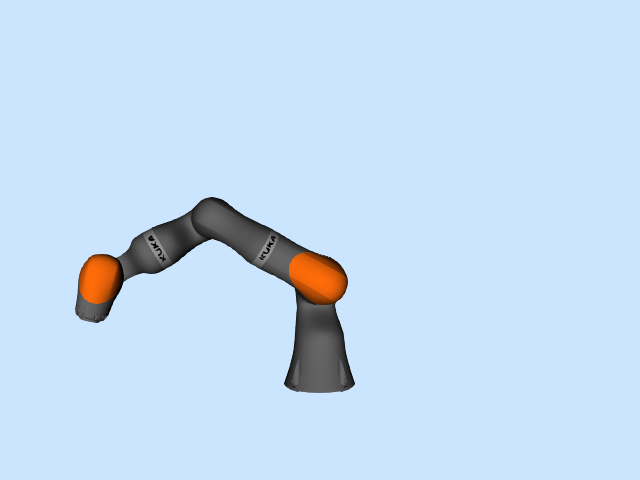

In [6]:
q = np.deg2rad([-75, 60, 0, -60, 0, 45, 0])
plant.SetPositions(plant_context, iiwa, q)

color = sensor.color_image_output_port().Eval(sensor_context).data
Image.fromarray(color)

In [7]:
for i in range(plant.num_frames()):
    frame = plant.get_frame(FrameIndex(i))
    print(GetScopedFrameName(plant, frame))

world
iiwa::iiwa_link_0
iiwa::iiwa_link_1
iiwa::iiwa_link_2
iiwa::iiwa_link_3
iiwa::iiwa_link_4
iiwa::iiwa_link_5
iiwa::iiwa_link_6
iiwa::iiwa_link_7
iiwa::__model__
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa
iiwa


## Compute Jacobian

Use velocity Jacobian, 'cause acceleration and forces.

For more details about notation:
<https://drake.mit.edu/doxygen_cxx/group__multibody__quantities.html>

In [8]:
# Select some frames to compute velocity Jacobian.
frame_W = plant.world_frame()
frame_G = plant.GetFrameByName("iiwa_link_7", iiwa)
Jv_WG = plant.CalcJacobianSpatialVelocity(
    plant_context,
    with_respect_to=JacobianWrtVariable.kV,
    frame_B=frame_G,
    p_BP=[0, 0, 0],
    frame_A=frame_W,
    frame_E=frame_W,
)
print(Jv_WG)

[[0.0000 0.9659 0.2241 -0.9659 0.2241 0.9659 0.0670]
 [0.0000 0.2588 -0.8365 -0.2588 -0.8365 0.2588 -0.2500]
 [1.0000 -0.0000 0.5000 -0.0000 -0.5000 -0.0000 -0.9659]
 [0.7062 -0.0177 0.4102 0.0720 0.0553 -0.0202 0.0000]
 [0.1892 0.0659 0.1099 -0.2688 0.0148 0.0756 0.0000]
 [0.0000 -0.7311 -0.0000 0.3674 0.0000 -0.0210 0.0000]]


# Compute joint forces given a load.

Use $\tau = J^T F$.

**TODO(eric)**: Find a good reference for virtual work / whatever principle that derives
this relationship.

In [9]:
m = 10  # kg
g = plant.gravity_field().gravity_vector()
F_G_W = SpatialForce(tau=[0, 0, 0], f=m * g)
tau_G_W = Jv_WG.T @ F_G_W.get_coeffs()
print(tau_G_W)

[0.0000 71.7214 0.0000 -36.0394 -0.0000 2.0566 0.0000]


In [10]:
def calc_F(J, tau):
    # Recompute spatial force from generalized forces.
    F, _, _, _ = np.linalg.lstsq(J.transpose(), tau, rcond=None)
    return SpatialForce(F)

In [11]:
F_G_W_recalc = calc_F(Jv_WG, tau_G_W)
print(F_G_W_recalc.get_coeffs())

[-0.0000 0.0000 0.0000 -0.0000 0.0000 -98.1000]
